# **PRÀCTICA 1: Identificació d'idioma**

# Main program

## Setup

In [2]:
import math
import nltk
from nltk.collocations import TrigramCollocationFinder
import json
import os
from typing import Callable

In [3]:
# Load trigrams and unique characters from json files
def dict_string_to_trigramtuple(d: dict) -> dict:
    return {key: {tuple(k): v for k, v in value.items()} for key, value in d.items()}

def refactor_validation(d: dict) -> dict:
    return {key: ({tuple(k2): v2 for k2, v2 in value[0].items()}, value[1]) for key, value in d.items()}

trigrams = dict_string_to_trigramtuple(json.load(open('./weights/trigrams.json')))
unique_chars = json.load(open('./weights/unique_chars.json'))

# Load preprocessed data (train and test)
train = json.load(open('./preprocessed_langId/train.json'))
test = json.load(open('./preprocessed_langId/test.json'))

validation_trigrams = refactor_validation(json.load(open('./weights/validation_trigrams.json')))
validation_unique = json.load(open('./weights/validation_unique_chars.json'))


In [ ]:
# Dictionaries to optimize Lidstone smoothing calculation
b_dict = {key: value ** 3 for key, value in unique_chars.items()}
totals = {key: sum(trigrams[key].values()) for key in trigrams.keys()}

# Functions for Lidstone smoothing
def lidstone_smooth(language: str, trigram: tuple, lambda_value: float = 0.5, b_values: dict = b_dict, model: dict = trigrams, total: dict = totals):
    counts = model[language]
    vocab = b_values[language]
    total_tri = total[language]
    number = counts.get(trigram, 0)
    probs = (number + lambda_value) / (total_tri + lambda_value * vocab)
    return probs

def pau_discounting(language: str, trigram: tuple, delta: float = 0.1, b_values:dict = b_dict, model: dict = trigrams, total: dict = totals):
    counts = model[language]
    total_tri = total[language]
    number = counts.get(trigram, 0)
    unique = len(counts)
    prob = max(number - delta, 0) / total_tri + (delta * unique / total_tri) * (1 / unique)
    return prob

def absolute_discounting(language: str, trigram: tuple, alpha: float = 0.1, b_values: dict = b_dict, model: dict = trigrams, total: dict = totals):
    counts = model[language]
    vocab = b_values[language]
    total_tri = total[language]
    count_trigram = counts.get(trigram, 0)
    unique = len(counts)
    if count_trigram == 0:
        prob = ((vocab - unique)*alpha/unique)/total_tri
    else:
        prob = ((count_trigram - alpha)/ total_tri)
    return prob

def linear_discounting(language: str, trigram: tuple, alpha: float = 0.1, b_values: dict = b_dict, model: dict = trigrams, total: dict = totals):
    counts = model[language]
    vocab = b_values[language]
    total_tri = total[language]
    count_trigram = counts.get(trigram, 0)
    if count_trigram == 0:
        prob = alpha / (vocab - len(counts))
    else:
        prob = (1-alpha)*(count_trigram / total_tri)
    return prob

def probs_total(text: str, language: str, smooth: Callable = lidstone_smooth, param: float = 0.5, b_values: dict = b_dict, probabilities: dict = None, total_values: dict = totals):
    trigram_finder = TrigramCollocationFinder.from_words(text)
    prob_sec = 0
    if probabilities == None:
        for trigram, num_instances in trigram_finder.ngram_fd.items():
            prob_sec += num_instances * math.log(smooth(language, trigram, param, b_values, total = total_values))
    else:
        for trigram, num_instances in trigram_finder.ngram_fd.items():
            prob_sec += num_instances * probabilities[language].get(trigram,math.log(smooth(language, trigram, param, b_values, total= total_values)) )
    return prob_sec

In [164]:
# Test the Lidstone smoothing
text = 'Example'
probs = []
languages = {"deu": "Deutsch (German)", 
             "eng": "English (English)", 
             "fra": "Français (French)", 
             "ita": "Italiano (Italian)", 
             "spa": "Español (Spanish)", 
             "nld": "Nederlands (Dutch)"}
             
for language in trigrams.keys():
    prob = probs_total(text, language)
    probs.append((language, prob))
max_probs = max(probs, key = lambda x: x[1])
print(max_probs)
probs = sorted(probs, key = lambda x: x[1], reverse=True)

# Normalize the probabilities and print the results
exp = [math.exp(p[1] - max_probs[1]) for p in probs]
normalize = [(e / sum (exp))*100 for e in exp]
lang = [languages[p[0]] for p in probs]
for e in range(len(lang)):
    print(f"{lang[e]}: {normalize[e]}")

('eng', -49.66172171035015)
English (English): 78.95978533444476
Français (French): 13.955759623805367
Español (Spanish): 6.3351454264507945
Nederlands (Dutch): 0.7010830052725817
Italiano (Italian): 0.04359962121678018
Deutsch (German): 0.004626988809744171


## Validation

In [117]:
unique_trigrams = set()
for k in trigrams.keys():
    unique_trigrams.update(set(trigrams[k].keys()))

def create_prob_dict(smooth: Callable = lidstone_smooth, param: float = 0.5, b_values: dict = b_dict, model: dict = trigrams, total: dict = totals, unique: dict = unique_trigrams):
    d = {}
    for lang in languages.keys():
        probab = {tri: math.log(smooth(lang, tri, param, b_values, model, total)) for tri in unique}
        d[lang] = probab
    return d
prob_dict = create_prob_dict()


In [30]:
val_train = {key: value[0] for key, value in validation_trigrams.items()}
val_test = {key: value[1] for key, value in validation_trigrams.items()}

In [174]:
def accuracy_validation(smooth: Callable = lidstone_smooth, param: float = 0.5):
    validation_errors = []
    b_values = {key: value ** 3 for key, value in validation_unique.items()}
    totals_val = {key: sum(val_train[key].values()) for key in val_train.keys()}
    probabilities = create_prob_dict(smooth, param, b_values, val_train,  totals_val, unique_trigrams)
    for lang in languages.keys():
        for sentence in val_test[lang]:
            probs = []
            for ling in languages.keys():
                prob = probs_total(sentence, ling, smooth, param, b_values, probabilities, totals_val)
                probs.append((ling, prob))
            max_prob = max(probs, key = lambda x: x[1])
            if max_prob[0] != lang:
                validation_errors.append({"text": sentence, "true": lang, "pred": max_prob[0]})
    return validation_errors

In [ ]:
smoothing_functions = [lidstone_smooth, linear_discounting, absolute_discounting, pau_discounting]
alphas = [0.05, 0.1, 0.25, 0.3, 0.5, 0.7, 1]
bees = [{key: value ** 3 for key, value in unique_chars.items()}, {key: len(value) for key, value in trigrams.items()}, {key: ((value ** 3)+len(trigrams[key]))/2 for key, value in unique_chars.items()}]

i = 0
for func in smoothing_functions:
    for alph in alphas:
        print(f"Iteration {i}: alpha {alph}, smoothing {func.__name__}")
        err = accuracy_validation(func, alph)
        print(f"{len(err)} errors.")
        i += 1


## Test

Total errors: 89 out of 59977 sentences.
Total accuracy: 0.9985160978375044
*Accuracy deu: 0.9988988988988989
*Accuracy eng: 0.9995994793231201
*Accuracy fra: 0.9983
*Accuracy ita: 0.9981
*Accuracy nld: 0.9973
*Accuracy spa: 0.9989


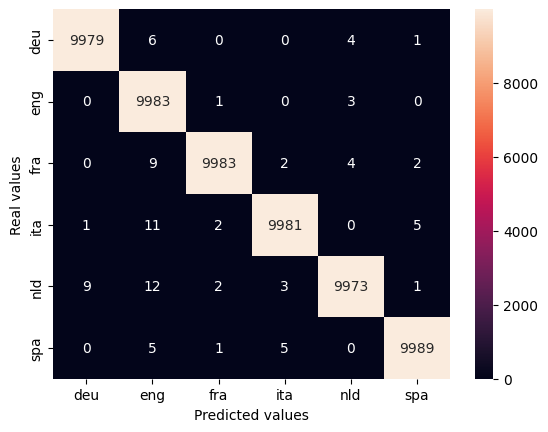

WRONG PREDICTIONS:
*True: deu, Predicted: eng, Text: "all das hat otto normal patient nicht."
*True: deu, Predicted: spa, Text: "autos wie den dacia sandero."
*True: deu, Predicted: nld, Text: "bildergalerie teilen der donkervoort d gto ist ja per se nicht gerade ein warmduscherauto."
*True: deu, Predicted: eng, Text: "darunter das restaurant mappamondo und der takeawaybetrieb the beef burger."
*True: deu, Predicted: nld, Text: "der stoffbeutel war leer."
*True: deu, Predicted: nld, Text: "hij was de leider van de groep in de provincie khorasan van de islamitische staat."
*True: deu, Predicted: eng, Text: "ist das land bald insolvent?"
*True: deu, Predicted: eng, Text: "jarjarthomas . jan theorethisch ist es simpel."
*True: deu, Predicted: eng, Text: "was ist wicop?"
*True: deu, Predicted: nld, Text: "wat er nu gebeurt, is heel zwaar voor hem als jonge gast."
*True: deu, Predicted: eng, Text: "wer wird wohl the one?"
*True: eng, Predicted: nld, Text: "in asia, japan's nikkei ."
*True: 

In [118]:
# Test
prediction_errors_list = []
predictions = {language: [] for language in test.keys()}

for language in test.keys():
	for sentence in test[language]:
		probs = []
		for lingua in trigrams.keys():
			prob = probs_total(sentence, lingua, lidstone_smooth, 0.5, probabilities=prob_dict)
			probs.append((lingua, prob))
		max_prob = max(probs, key = lambda x: x[1])
		predictions[language].append(max_prob[0])
		if max_prob[0] != language:
			prediction_errors_list.append({"text": sentence, "true": language, "pred": max_prob[0]})

# Calculate accuracy
correct_predictions = {language: sum([1 for pred in predictions[language] if pred == language]) for language in test.keys()}
total_accuracy = sum(correct_predictions.values()) / sum([len(value) for value in test.values()])

# Print results
print(f"Total errors: {len(prediction_errors_list)} out of {sum([len(value) for value in test.values()])} sentences.")
print(f"Total accuracy: {total_accuracy}")
for language, correct in correct_predictions.items():
	print(f"*Accuracy {language}: {correct / len(test[language])}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

language_names = [language for language in test.keys()]

cm = confusion_matrix(y_true=[language for language in test.keys() for _ in range(len(test[language]))],
					  y_pred=[pred for language in test.keys() for pred in predictions[language]],
					  labels=language_names)

sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=language_names, yticklabels=language_names)
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.show()

# Print the errors
print("WRONG PREDICTIONS:")
for error in prediction_errors_list:
	print(f"*True: {error['true']}, Predicted: {error['pred']}, Text: \"{error['text']}\"")